In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'random_occlusion'}
Validation folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'random_occlusion'}
Test folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'random_occlusion'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise'}
Validation folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise'}
Test folders considered: {'chromatic_aberration', 'low_resolution', 'original', 'blur', 'lens_flare', 'motion_blur', 'dirty_lens', 'gaussian_noise'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Fixed Xception Architecture from Scratch
# -----------------------------

class SeparableConv2d(nn.Module):
    """Depthwise Separable Convolution - Core of Xception"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=bias)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class XceptionBlock(nn.Module):
    """Fixed Xception Block with skip connections"""
    def __init__(self, in_channels, out_channels, reps, stride=1, start_with_relu=True, grow_first=True):
        super(XceptionBlock, self).__init__()
        
        # Skip connection if needed
        self.skip = None
        if out_channels != in_channels or stride != 1:
            self.skip = nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False)
            self.skipbn = nn.BatchNorm2d(out_channels)
        
        rep = []
        filters = in_channels
        
        if grow_first:
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(out_channels))
            filters = out_channels

        for i in range(reps - 1):
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=False))  # FIXED: inplace=False
            rep.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))
            rep.append(nn.BatchNorm2d(out_channels))

        if stride != 1:
            rep.append(nn.MaxPool2d(3, stride=stride, padding=1))
        
        self.rep = nn.Sequential(*rep)

    def forward(self, x):
        output = self.rep(x)
        
        if self.skip is not None:
            skip = self.skip(x)
            skip = self.skipbn(skip)
        else:
            skip = x
        
        output += skip
        return output

class Xception(nn.Module):
    """Fixed Xception Network Architecture from Scratch"""
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()
        
        # Entry Flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=False)  # FIXED: inplace=False
        
        self.conv2 = nn.Conv2d(32, 64, 3, bias=False, padding=1)  # FIXED: added padding
        self.bn2 = nn.BatchNorm2d(64)
        
        self.block1 = XceptionBlock(64, 128, 2, stride=2, start_with_relu=False, grow_first=True)
        self.block2 = XceptionBlock(128, 256, 2, stride=2, start_with_relu=True, grow_first=True)
        self.block3 = XceptionBlock(256, 728, 2, stride=2, start_with_relu=True, grow_first=True)
        
        # Middle Flow (repeated 8 times)
        self.block4 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block5 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block6 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block7 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block8 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block9 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block10 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        self.block11 = XceptionBlock(728, 728, 3, stride=1, start_with_relu=True, grow_first=True)
        
        # Exit Flow
        self.block12 = XceptionBlock(728, 1024, 2, stride=2, start_with_relu=True, grow_first=False)
        
        self.conv3 = SeparableConv2d(1024, 1536, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(1536)
        
        self.conv4 = SeparableConv2d(1536, 2048, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(2048)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, num_classes)
        
        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Entry Flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Middle Flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        
        # Exit Flow
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        # Final classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# -----------------------------
# 2. Data Preprocessing with Filtering (Xception - 299x299)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# Xception training from scratch - with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation for scratch training
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

transform_val_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("üîÑ Loading and filtering datasets for Xception (scratch training)...")
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform_train)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform_val_test)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform_val_test)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)  # Smaller batch for scratch training
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"‚úÖ Classes: {classes}")
print(f"üìä Dataset Statistics:")
print(f"‚îÇ Training images: {len(train_ds)}")
print(f"‚îÇ Validation images: {len(val_ds)}")
print(f"‚îÇ Test images: {len(test_ds)}")
print(f"‚îÇ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"‚îÇ Excluded folder: '{ignore_folder}'")
print(f"‚îÇ Number of classes: {len(classes)}")

# -----------------------------
# 3. Model Setup for Scratch Training
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create Xception model from scratch
print("üîÑ Creating Xception model from scratch...")
model = Xception(num_classes=len(classes))
model = model.to(device)

print(f"‚úÖ Model created with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"üìä Total parameters: {total_params:,}")
print(f"üìä Trainable parameters: {trainable_params:,}")
print(f"üìã Model Architecture:")
print(f"‚îÇ Input size: (3, 299, 299)")
print(f"‚îÇ Xception features: 2048")
print(f"‚îÇ Output classes: {len(classes)}")
print(f"‚îÇ Training: From scratch (no pretrained weights)")
print(f"‚îÇ Data augmentation: Enabled for robust training")

üîÑ Loading and filtering datasets for Xception (scratch training)...
‚úÖ Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']
üìä Dataset Statistics:
‚îÇ Training images: 9928
‚îÇ Validation images: 2576
‚îÇ Test images: 3224
‚îÇ Total images (after filtering): 15728
‚îÇ Excluded folder: 'random_occlusion'
‚îÇ Number of classes: 4
Using device: cuda
üîÑ Creating Xception model from scratch...
‚úÖ Model created with 4 output classes
üìä Total parameters: 20,815,148
üìä Trainable parameters: 20,815,148
üìã Model Architecture:
‚îÇ Input size: (3, 299, 299)
‚îÇ Xception features: 2048
‚îÇ Output classes: 4
‚îÇ Training: From scratch (no pretrained weights)
‚îÇ Data augmentation: Enabled for robust training



üìã Training Configuration:
‚îÇ Model: Xception (from scratch)
‚îÇ Optimizer: Adam (lr=0.001)
‚îÇ Weight Decay: 1e-4
‚îÇ Loss Function: CrossEntropyLoss
‚îÇ Batch Size: 16
‚îÇ LR Scheduler: StepLR (decay every 10 epochs)
‚îÇ Device: cuda
‚îÇ Data: Filtered + Augmented

üöÄ Starting Xception Training from Scratch for 50 epochs...

üìà Epoch 1/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:33<00:00,  1.65s/it, Loss=1.1390, Acc=0.5183, GPU=0.3GB]


‚úÖ Training completed in 513.20s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:50<00:00,  1.59it/s, Loss=1.1206, Acc=0.5532]


‚úÖ Validation completed in 50.93s
üåü New best model found! Validation Accuracy: 0.5532

üìä Epoch 1 Summary:
‚îÇ Train Loss: 1.1390 | Train Acc: 0.5183
‚îÇ Val Loss:   1.1206 | Val Acc:   0.5532
‚îÇ Train Time: 513.20s | Val Time: 50.93s
‚îÇ Total Epoch Time: 564.14s
‚îÇ Best Val Acc: 0.5532 (Epoch 1)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 2/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:14<00:00,  1.59s/it, Loss=1.0315, Acc=0.5734, GPU=0.3GB]


‚úÖ Training completed in 494.54s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=1.0824, Acc=0.5656]


‚úÖ Validation completed in 44.76s
üåü New best model found! Validation Accuracy: 0.5656

üìä Epoch 2 Summary:
‚îÇ Train Loss: 1.0315 | Train Acc: 0.5734
‚îÇ Val Loss:   1.0824 | Val Acc:   0.5656
‚îÇ Train Time: 494.54s | Val Time: 44.76s
‚îÇ Total Epoch Time: 539.31s
‚îÇ Best Val Acc: 0.5656 (Epoch 2)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 3/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:14<00:00,  1.59s/it, Loss=0.9273, Acc=0.6234, GPU=0.3GB]


‚úÖ Training completed in 494.94s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=1.0715, Acc=0.5951]


‚úÖ Validation completed in 44.71s
üåü New best model found! Validation Accuracy: 0.5951

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.9273 | Train Acc: 0.6234
‚îÇ Val Loss:   1.0715 | Val Acc:   0.5951
‚îÇ Train Time: 494.94s | Val Time: 44.71s
‚îÇ Total Epoch Time: 539.66s
‚îÇ Best Val Acc: 0.5951 (Epoch 3)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 4/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:13<00:00,  1.59s/it, Loss=0.8062, Acc=0.6681, GPU=0.3GB]


‚úÖ Training completed in 493.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=1.2679, Acc=0.5734]


‚úÖ Validation completed in 44.47s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.8062 | Train Acc: 0.6681
‚îÇ Val Loss:   1.2679 | Val Acc:   0.5734
‚îÇ Train Time: 493.22s | Val Time: 44.47s
‚îÇ Total Epoch Time: 537.69s
‚îÇ Best Val Acc: 0.5951 (Epoch 3)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 5/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:14<00:00,  1.59s/it, Loss=0.7298, Acc=0.7106, GPU=0.3GB]


‚úÖ Training completed in 494.02s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.9188, Acc=0.6231]


‚úÖ Validation completed in 44.74s
üåü New best model found! Validation Accuracy: 0.6231

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.7298 | Train Acc: 0.7106
‚îÇ Val Loss:   0.9188 | Val Acc:   0.6231
‚îÇ Train Time: 494.02s | Val Time: 44.74s
‚îÇ Total Epoch Time: 538.77s
‚îÇ Best Val Acc: 0.6231 (Epoch 5)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 6/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:16<00:00,  1.60s/it, Loss=0.6428, Acc=0.7440, GPU=0.3GB]


‚úÖ Training completed in 496.26s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:45<00:00,  1.78it/s, Loss=0.9085, Acc=0.6689]


‚úÖ Validation completed in 45.45s
üåü New best model found! Validation Accuracy: 0.6689

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.6428 | Train Acc: 0.7440
‚îÇ Val Loss:   0.9085 | Val Acc:   0.6689
‚îÇ Train Time: 496.26s | Val Time: 45.45s
‚îÇ Total Epoch Time: 541.71s
‚îÇ Best Val Acc: 0.6689 (Epoch 6)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 7/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:13<00:00,  1.59s/it, Loss=0.5426, Acc=0.7910, GPU=0.3GB]


‚úÖ Training completed in 493.15s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:45<00:00,  1.79it/s, Loss=0.7182, Acc=0.7259]


‚úÖ Validation completed in 45.27s
üåü New best model found! Validation Accuracy: 0.7259

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.5426 | Train Acc: 0.7910
‚îÇ Val Loss:   0.7182 | Val Acc:   0.7259
‚îÇ Train Time: 493.15s | Val Time: 45.27s
‚îÇ Total Epoch Time: 538.43s
‚îÇ Best Val Acc: 0.7259 (Epoch 7)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 8/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:13<00:00,  1.59s/it, Loss=0.4699, Acc=0.8228, GPU=0.3GB]


‚úÖ Training completed in 493.51s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:45<00:00,  1.79it/s, Loss=0.6664, Acc=0.7562]


‚úÖ Validation completed in 45.30s
üåü New best model found! Validation Accuracy: 0.7562

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.4699 | Train Acc: 0.8228
‚îÇ Val Loss:   0.6664 | Val Acc:   0.7562
‚îÇ Train Time: 493.51s | Val Time: 45.30s
‚îÇ Total Epoch Time: 538.81s
‚îÇ Best Val Acc: 0.7562 (Epoch 8)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 9/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:12<00:00,  1.58s/it, Loss=0.3754, Acc=0.8599, GPU=0.3GB]


‚úÖ Training completed in 492.84s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:45<00:00,  1.80it/s, Loss=0.8454, Acc=0.7290]


‚úÖ Validation completed in 45.01s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.3754 | Train Acc: 0.8599
‚îÇ Val Loss:   0.8454 | Val Acc:   0.7290
‚îÇ Train Time: 492.84s | Val Time: 45.01s
‚îÇ Total Epoch Time: 537.85s
‚îÇ Best Val Acc: 0.7562 (Epoch 8)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 10/50
Current LR: 1.00e-03
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:15<00:00,  1.59s/it, Loss=0.3284, Acc=0.8768, GPU=0.3GB]


‚úÖ Training completed in 495.06s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.80it/s, Loss=0.6751, Acc=0.7554]


‚úÖ Validation completed in 44.94s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.3284 | Train Acc: 0.8768
‚îÇ Val Loss:   0.6751 | Val Acc:   0.7554
‚îÇ Train Time: 495.06s | Val Time: 44.94s
‚îÇ Total Epoch Time: 540.00s
‚îÇ Best Val Acc: 0.7562 (Epoch 8)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 11/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:12<00:00,  1.58s/it, Loss=0.1784, Acc=0.9360, GPU=0.3GB]


‚úÖ Training completed in 492.42s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.6131, Acc=0.7915]


‚úÖ Validation completed in 44.67s
üåü New best model found! Validation Accuracy: 0.7915

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.1784 | Train Acc: 0.9360
‚îÇ Val Loss:   0.6131 | Val Acc:   0.7915
‚îÇ Train Time: 492.42s | Val Time: 44.67s
‚îÇ Total Epoch Time: 537.10s
‚îÇ Best Val Acc: 0.7915 (Epoch 11)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 12/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:09<00:00,  1.58s/it, Loss=0.1281, Acc=0.9570, GPU=0.3GB]


‚úÖ Training completed in 489.91s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.6329, Acc=0.7900]


‚úÖ Validation completed in 44.61s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.1281 | Train Acc: 0.9570
‚îÇ Val Loss:   0.6329 | Val Acc:   0.7900
‚îÇ Train Time: 489.91s | Val Time: 44.61s
‚îÇ Total Epoch Time: 534.52s
‚îÇ Best Val Acc: 0.7915 (Epoch 11)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 13/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:10<00:00,  1.58s/it, Loss=0.1088, Acc=0.9622, GPU=0.3GB]


‚úÖ Training completed in 490.23s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.6507, Acc=0.7993]


‚úÖ Validation completed in 44.59s
üåü New best model found! Validation Accuracy: 0.7993

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.1088 | Train Acc: 0.9622
‚îÇ Val Loss:   0.6507 | Val Acc:   0.7993
‚îÇ Train Time: 490.23s | Val Time: 44.59s
‚îÇ Total Epoch Time: 534.83s
‚îÇ Best Val Acc: 0.7993 (Epoch 13)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 14/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0967, Acc=0.9697, GPU=0.3GB]


‚úÖ Training completed in 490.83s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.6919, Acc=0.7927]


‚úÖ Validation completed in 44.88s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.0967 | Train Acc: 0.9697
‚îÇ Val Loss:   0.6919 | Val Acc:   0.7927
‚îÇ Train Time: 490.83s | Val Time: 44.88s
‚îÇ Total Epoch Time: 535.71s
‚îÇ Best Val Acc: 0.7993 (Epoch 13)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 15/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0844, Acc=0.9746, GPU=0.3GB]


‚úÖ Training completed in 490.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.6926, Acc=0.8063]


‚úÖ Validation completed in 44.65s
üåü New best model found! Validation Accuracy: 0.8063

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.0844 | Train Acc: 0.9746
‚îÇ Val Loss:   0.6926 | Val Acc:   0.8063
‚îÇ Train Time: 490.79s | Val Time: 44.65s
‚îÇ Total Epoch Time: 535.45s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 16/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0782, Acc=0.9757, GPU=0.3GB]


‚úÖ Training completed in 497.85s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.71it/s, Loss=0.7140, Acc=0.7977]


‚úÖ Validation completed in 47.41s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.0782 | Train Acc: 0.9757
‚îÇ Val Loss:   0.7140 | Val Acc:   0.7977
‚îÇ Train Time: 497.85s | Val Time: 47.41s
‚îÇ Total Epoch Time: 545.26s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 17/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0675, Acc=0.9784, GPU=0.3GB]


‚úÖ Training completed in 497.80s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.69it/s, Loss=0.7479, Acc=0.7884]


‚úÖ Validation completed in 47.80s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.0675 | Train Acc: 0.9784
‚îÇ Val Loss:   0.7479 | Val Acc:   0.7884
‚îÇ Train Time: 497.80s | Val Time: 47.80s
‚îÇ Total Epoch Time: 545.60s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 18/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0656, Acc=0.9778, GPU=0.3GB]


‚úÖ Training completed in 497.23s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:48<00:00,  1.69it/s, Loss=0.7616, Acc=0.7892]


‚úÖ Validation completed in 48.03s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.0656 | Train Acc: 0.9778
‚îÇ Val Loss:   0.7616 | Val Acc:   0.7892
‚îÇ Train Time: 497.23s | Val Time: 48.03s
‚îÇ Total Epoch Time: 545.26s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 19/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:15<00:00,  1.59s/it, Loss=0.0552, Acc=0.9820, GPU=0.3GB]


‚úÖ Training completed in 495.57s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.70it/s, Loss=0.7802, Acc=0.7884]


‚úÖ Validation completed in 47.71s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.0552 | Train Acc: 0.9820
‚îÇ Val Loss:   0.7802 | Val Acc:   0.7884
‚îÇ Train Time: 495.57s | Val Time: 47.71s
‚îÇ Total Epoch Time: 543.28s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 20/50
Current LR: 1.00e-04
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0537, Acc=0.9855, GPU=0.3GB]


‚úÖ Training completed in 497.80s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8671, Acc=0.7900]


‚úÖ Validation completed in 47.80s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0537 | Train Acc: 0.9855
‚îÇ Val Loss:   0.8671 | Val Acc:   0.7900
‚îÇ Train Time: 497.80s | Val Time: 47.80s
‚îÇ Total Epoch Time: 545.60s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 21/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:13<00:00,  1.59s/it, Loss=0.0471, Acc=0.9851, GPU=0.3GB]


‚úÖ Training completed in 493.75s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8374, Acc=0.7904]


‚úÖ Validation completed in 44.62s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0471 | Train Acc: 0.9851
‚îÇ Val Loss:   0.8374 | Val Acc:   0.7904
‚îÇ Train Time: 493.75s | Val Time: 44.62s
‚îÇ Total Epoch Time: 538.38s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 22/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:12<00:00,  1.58s/it, Loss=0.0426, Acc=0.9875, GPU=0.3GB]


‚úÖ Training completed in 492.01s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8251, Acc=0.7927]


‚úÖ Validation completed in 47.88s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0426 | Train Acc: 0.9875
‚îÇ Val Loss:   0.8251 | Val Acc:   0.7927
‚îÇ Train Time: 492.01s | Val Time: 47.88s
‚îÇ Total Epoch Time: 539.90s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 23/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:18<00:00,  1.60s/it, Loss=0.0388, Acc=0.9876, GPU=0.3GB]


‚úÖ Training completed in 498.23s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:46<00:00,  1.74it/s, Loss=0.8211, Acc=0.7888]


‚úÖ Validation completed in 46.51s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0388 | Train Acc: 0.9876
‚îÇ Val Loss:   0.8211 | Val Acc:   0.7888
‚îÇ Train Time: 498.23s | Val Time: 46.51s
‚îÇ Total Epoch Time: 544.75s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 24/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0412, Acc=0.9863, GPU=0.3GB]


‚úÖ Training completed in 490.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.72it/s, Loss=0.8461, Acc=0.7931]


‚úÖ Validation completed in 47.01s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0412 | Train Acc: 0.9863
‚îÇ Val Loss:   0.8461 | Val Acc:   0.7931
‚îÇ Train Time: 490.17s | Val Time: 47.01s
‚îÇ Total Epoch Time: 537.19s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 25/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0390, Acc=0.9882, GPU=0.3GB]


‚úÖ Training completed in 497.82s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:48<00:00,  1.69it/s, Loss=0.8296, Acc=0.7904]


‚úÖ Validation completed in 48.03s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0390 | Train Acc: 0.9882
‚îÇ Val Loss:   0.8296 | Val Acc:   0.7904
‚îÇ Train Time: 497.82s | Val Time: 48.03s
‚îÇ Total Epoch Time: 545.86s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 26/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:17<00:00,  1.60s/it, Loss=0.0347, Acc=0.9897, GPU=0.3GB]


‚úÖ Training completed in 497.14s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.72it/s, Loss=0.8338, Acc=0.7892]


‚úÖ Validation completed in 47.19s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0347 | Train Acc: 0.9897
‚îÇ Val Loss:   0.8338 | Val Acc:   0.7892
‚îÇ Train Time: 497.14s | Val Time: 47.19s
‚îÇ Total Epoch Time: 544.34s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 27/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:14<00:00,  1.59s/it, Loss=0.0370, Acc=0.9883, GPU=0.3GB]


‚úÖ Training completed in 494.92s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:46<00:00,  1.73it/s, Loss=0.8360, Acc=0.7915]


‚úÖ Validation completed in 46.81s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0370 | Train Acc: 0.9883
‚îÇ Val Loss:   0.8360 | Val Acc:   0.7915
‚îÇ Train Time: 494.92s | Val Time: 46.81s
‚îÇ Total Epoch Time: 541.73s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 28/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:09<00:00,  1.57s/it, Loss=0.0333, Acc=0.9901, GPU=0.3GB]


‚úÖ Training completed in 489.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8248, Acc=0.7896]


‚úÖ Validation completed in 44.73s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0333 | Train Acc: 0.9901
‚îÇ Val Loss:   0.8248 | Val Acc:   0.7896
‚îÇ Train Time: 489.18s | Val Time: 44.73s
‚îÇ Total Epoch Time: 533.92s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 29/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [09:02<00:00,  1.74s/it, Loss=0.0348, Acc=0.9879, GPU=0.3GB]


‚úÖ Training completed in 542.68s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [01:17<00:00,  1.04it/s, Loss=0.8291, Acc=0.7849]


‚úÖ Validation completed in 77.63s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0348 | Train Acc: 0.9879
‚îÇ Val Loss:   0.8291 | Val Acc:   0.7849
‚îÇ Train Time: 542.68s | Val Time: 77.63s
‚îÇ Total Epoch Time: 620.31s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 30/50
Current LR: 1.00e-05
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [09:22<00:00,  1.81s/it, Loss=0.0316, Acc=0.9903, GPU=0.3GB]


‚úÖ Training completed in 562.11s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.70it/s, Loss=0.8452, Acc=0.7927]


‚úÖ Validation completed in 47.70s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0316 | Train Acc: 0.9903
‚îÇ Val Loss:   0.8452 | Val Acc:   0.7927
‚îÇ Train Time: 562.11s | Val Time: 47.70s
‚îÇ Total Epoch Time: 609.81s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 31/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:14<00:00,  1.59s/it, Loss=0.0329, Acc=0.9904, GPU=0.3GB]


‚úÖ Training completed in 494.83s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.71it/s, Loss=0.8876, Acc=0.7869]


‚úÖ Validation completed in 47.33s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0329 | Train Acc: 0.9904
‚îÇ Val Loss:   0.8876 | Val Acc:   0.7869
‚îÇ Train Time: 494.83s | Val Time: 47.33s
‚îÇ Total Epoch Time: 542.16s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 32/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:26<00:00,  1.63s/it, Loss=0.0391, Acc=0.9874, GPU=0.3GB]


‚úÖ Training completed in 506.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.70it/s, Loss=0.8593, Acc=0.7896]


‚úÖ Validation completed in 47.74s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0391 | Train Acc: 0.9874
‚îÇ Val Loss:   0.8593 | Val Acc:   0.7896
‚îÇ Train Time: 506.22s | Val Time: 47.74s
‚îÇ Total Epoch Time: 553.97s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 33/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:13<00:00,  1.59s/it, Loss=0.0339, Acc=0.9897, GPU=0.3GB]


‚úÖ Training completed in 493.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:45<00:00,  1.79it/s, Loss=0.8570, Acc=0.7861]


‚úÖ Validation completed in 45.14s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0339 | Train Acc: 0.9897
‚îÇ Val Loss:   0.8570 | Val Acc:   0.7861
‚îÇ Train Time: 493.77s | Val Time: 45.14s
‚îÇ Total Epoch Time: 538.91s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 34/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:11<00:00,  1.58s/it, Loss=0.0353, Acc=0.9889, GPU=0.3GB]


‚úÖ Training completed in 491.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8558, Acc=0.7927]


‚úÖ Validation completed in 44.72s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0353 | Train Acc: 0.9889
‚îÇ Val Loss:   0.8558 | Val Acc:   0.7927
‚îÇ Train Time: 491.79s | Val Time: 44.72s
‚îÇ Total Epoch Time: 536.51s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 35/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0306, Acc=0.9904, GPU=0.3GB]


‚úÖ Training completed in 486.41s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8585, Acc=0.7923]


‚úÖ Validation completed in 44.75s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0306 | Train Acc: 0.9904
‚îÇ Val Loss:   0.8585 | Val Acc:   0.7923
‚îÇ Train Time: 486.41s | Val Time: 44.75s
‚îÇ Total Epoch Time: 531.16s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 36/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:07<00:00,  1.57s/it, Loss=0.0324, Acc=0.9904, GPU=0.3GB]


‚úÖ Training completed in 487.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.83it/s, Loss=0.8458, Acc=0.7853]


‚úÖ Validation completed in 44.38s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0324 | Train Acc: 0.9904
‚îÇ Val Loss:   0.8458 | Val Acc:   0.7853
‚îÇ Train Time: 487.22s | Val Time: 44.38s
‚îÇ Total Epoch Time: 531.60s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 37/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0329, Acc=0.9902, GPU=0.3GB]


‚úÖ Training completed in 490.37s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8569, Acc=0.7896]


‚úÖ Validation completed in 44.58s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0329 | Train Acc: 0.9902
‚îÇ Val Loss:   0.8569 | Val Acc:   0.7896
‚îÇ Train Time: 490.37s | Val Time: 44.58s
‚îÇ Total Epoch Time: 534.95s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 38/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:07<00:00,  1.57s/it, Loss=0.0320, Acc=0.9894, GPU=0.3GB]


‚úÖ Training completed in 487.62s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8407, Acc=0.7892]


‚úÖ Validation completed in 44.61s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0320 | Train Acc: 0.9894
‚îÇ Val Loss:   0.8407 | Val Acc:   0.7892
‚îÇ Train Time: 487.62s | Val Time: 44.61s
‚îÇ Total Epoch Time: 532.23s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 39/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:08<00:00,  1.57s/it, Loss=0.0310, Acc=0.9911, GPU=0.3GB]


‚úÖ Training completed in 488.21s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:46<00:00,  1.76it/s, Loss=0.8322, Acc=0.7927]


‚úÖ Validation completed in 46.09s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0310 | Train Acc: 0.9911
‚îÇ Val Loss:   0.8322 | Val Acc:   0.7927
‚îÇ Train Time: 488.21s | Val Time: 46.09s
‚îÇ Total Epoch Time: 534.31s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 40/50
Current LR: 1.00e-06
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:21<00:00,  1.61s/it, Loss=0.0352, Acc=0.9899, GPU=0.3GB]


‚úÖ Training completed in 501.64s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8329, Acc=0.7908]


‚úÖ Validation completed in 47.95s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0352 | Train Acc: 0.9899
‚îÇ Val Loss:   0.8329 | Val Acc:   0.7908
‚îÇ Train Time: 501.64s | Val Time: 47.95s
‚îÇ Total Epoch Time: 549.60s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 41/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:10<00:00,  1.58s/it, Loss=0.0309, Acc=0.9908, GPU=0.3GB]


‚úÖ Training completed in 490.12s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8462, Acc=0.7842]


‚úÖ Validation completed in 44.48s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0309 | Train Acc: 0.9908
‚îÇ Val Loss:   0.8462 | Val Acc:   0.7842
‚îÇ Train Time: 490.12s | Val Time: 44.48s
‚îÇ Total Epoch Time: 534.60s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 42/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:05<00:00,  1.56s/it, Loss=0.0343, Acc=0.9898, GPU=0.3GB]


‚úÖ Training completed in 485.41s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8337, Acc=0.7861]


‚úÖ Validation completed in 44.61s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0343 | Train Acc: 0.9898
‚îÇ Val Loss:   0.8337 | Val Acc:   0.7861
‚îÇ Train Time: 485.41s | Val Time: 44.61s
‚îÇ Total Epoch Time: 530.03s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 43/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0332, Acc=0.9892, GPU=0.3GB]


‚úÖ Training completed in 486.58s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.80it/s, Loss=0.8514, Acc=0.7869]


‚úÖ Validation completed in 44.97s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0332 | Train Acc: 0.9892
‚îÇ Val Loss:   0.8514 | Val Acc:   0.7869
‚îÇ Train Time: 486.58s | Val Time: 44.97s
‚îÇ Total Epoch Time: 531.55s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 44/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:09<00:00,  1.57s/it, Loss=0.0327, Acc=0.9902, GPU=0.3GB]


‚úÖ Training completed in 489.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:47<00:00,  1.69it/s, Loss=0.8499, Acc=0.7873]


‚úÖ Validation completed in 47.86s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0327 | Train Acc: 0.9902
‚îÇ Val Loss:   0.8499 | Val Acc:   0.7873
‚îÇ Train Time: 489.18s | Val Time: 47.86s
‚îÇ Total Epoch Time: 537.05s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 45/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:12<00:00,  1.58s/it, Loss=0.0331, Acc=0.9908, GPU=0.3GB]


‚úÖ Training completed in 492.66s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8559, Acc=0.7919]


‚úÖ Validation completed in 44.70s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0331 | Train Acc: 0.9908
‚îÇ Val Loss:   0.8559 | Val Acc:   0.7919
‚îÇ Train Time: 492.66s | Val Time: 44.70s
‚îÇ Total Epoch Time: 537.36s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 46/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0338, Acc=0.9910, GPU=0.3GB]


‚úÖ Training completed in 486.52s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8486, Acc=0.7873]


‚úÖ Validation completed in 44.56s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0338 | Train Acc: 0.9910
‚îÇ Val Loss:   0.8486 | Val Acc:   0.7873
‚îÇ Train Time: 486.52s | Val Time: 44.56s
‚îÇ Total Epoch Time: 531.08s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 47/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:05<00:00,  1.56s/it, Loss=0.0344, Acc=0.9889, GPU=0.3GB]


‚úÖ Training completed in 485.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8438, Acc=0.7911]


‚úÖ Validation completed in 44.76s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0344 | Train Acc: 0.9889
‚îÇ Val Loss:   0.8438 | Val Acc:   0.7911
‚îÇ Train Time: 485.77s | Val Time: 44.76s
‚îÇ Total Epoch Time: 530.53s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 48/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:04<00:00,  1.56s/it, Loss=0.0364, Acc=0.9882, GPU=0.3GB]


‚úÖ Training completed in 484.89s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.81it/s, Loss=0.8415, Acc=0.7888]


‚úÖ Validation completed in 44.67s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0364 | Train Acc: 0.9882
‚îÇ Val Loss:   0.8415 | Val Acc:   0.7888
‚îÇ Train Time: 484.89s | Val Time: 44.67s
‚îÇ Total Epoch Time: 529.56s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 49/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:05<00:00,  1.56s/it, Loss=0.0296, Acc=0.9919, GPU=0.3GB]


‚úÖ Training completed in 485.46s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.83it/s, Loss=0.8405, Acc=0.7896]


‚úÖ Validation completed in 44.17s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0296 | Train Acc: 0.9919
‚îÇ Val Loss:   0.8405 | Val Acc:   0.7896
‚îÇ Train Time: 485.46s | Val Time: 44.17s
‚îÇ Total Epoch Time: 529.64s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üìà Epoch 50/50
Current LR: 1.00e-07
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 311/311 [08:06<00:00,  1.56s/it, Loss=0.0290, Acc=0.9918, GPU=0.3GB]


‚úÖ Training completed in 486.12s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 81/81 [00:44<00:00,  1.82it/s, Loss=0.8412, Acc=0.7892]


‚úÖ Validation completed in 44.44s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0290 | Train Acc: 0.9918
‚îÇ Val Loss:   0.8412 | Val Acc:   0.7892
‚îÇ Train Time: 486.12s | Val Time: 44.44s
‚îÇ Total Epoch Time: 530.56s
‚îÇ Best Val Acc: 0.8063 (Epoch 15)
‚îÇ GPU Memory: 0.3GB / 9.0GB

üíæ Best model saved as 'best_cricket_xception_scratch_filtered.pth'
üìä Best model stats:
‚îÇ Best Epoch: 15
‚îÇ Best Val Acc: 0.8063
‚îÇ Best Val Loss: 0.6926

üíæ Training history saved to 'cricket_xception_scratch_filtered_history.csv'

üéâ Xception Scratch Training Complete!
Total Training Time: 27082.53s (451.4 minutes)
Average Epoch Time: 541.65s

üß™ Loading Best Model for Testing...
‚úÖ Best model from epoch 15 loaded successfully!


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 101/101 [01:13<00:00,  1.37it/s]


‚úÖ Testing completed in 73.53s

üìã Classification Report:
              precision    recall  f1-score   support

     Batting       0.84      0.87      0.85      1656
     Bowling       0.64      0.54      0.59       488
    Fielding       0.67      0.67      0.67       560
      Umpire       0.86      0.88      0.87       520

    accuracy                           0.79      3224
   macro avg       0.75      0.74      0.74      3224
weighted avg       0.78      0.79      0.78      3224

üéØ Test Accuracy: 0.7854

üìä Cricket Classification Performance (Xception - Scratch Training):
‚îÇ Best Validation Acc:  0.8063 (Epoch 15)
‚îÇ Best Validation Loss: 0.6926 (Epoch 15)
‚îÇ Final Test Accuracy:  0.7854
‚îÇ Val-Test Gap:         0.0209
‚îÇ Training Type: From scratch (no pretraining)

üíæ Files saved:
‚îÇ best_cricket_xception_scratch_filtered.pth - Best model weights
‚îÇ cricket_xception_scratch_filtered_history.csv - Training metrics


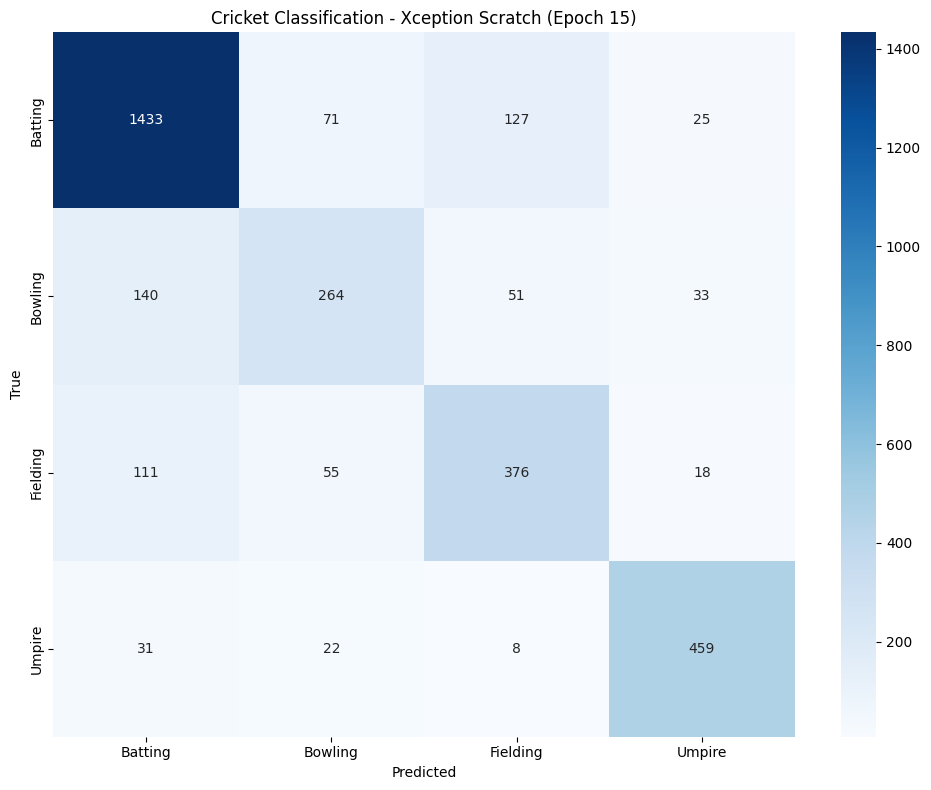

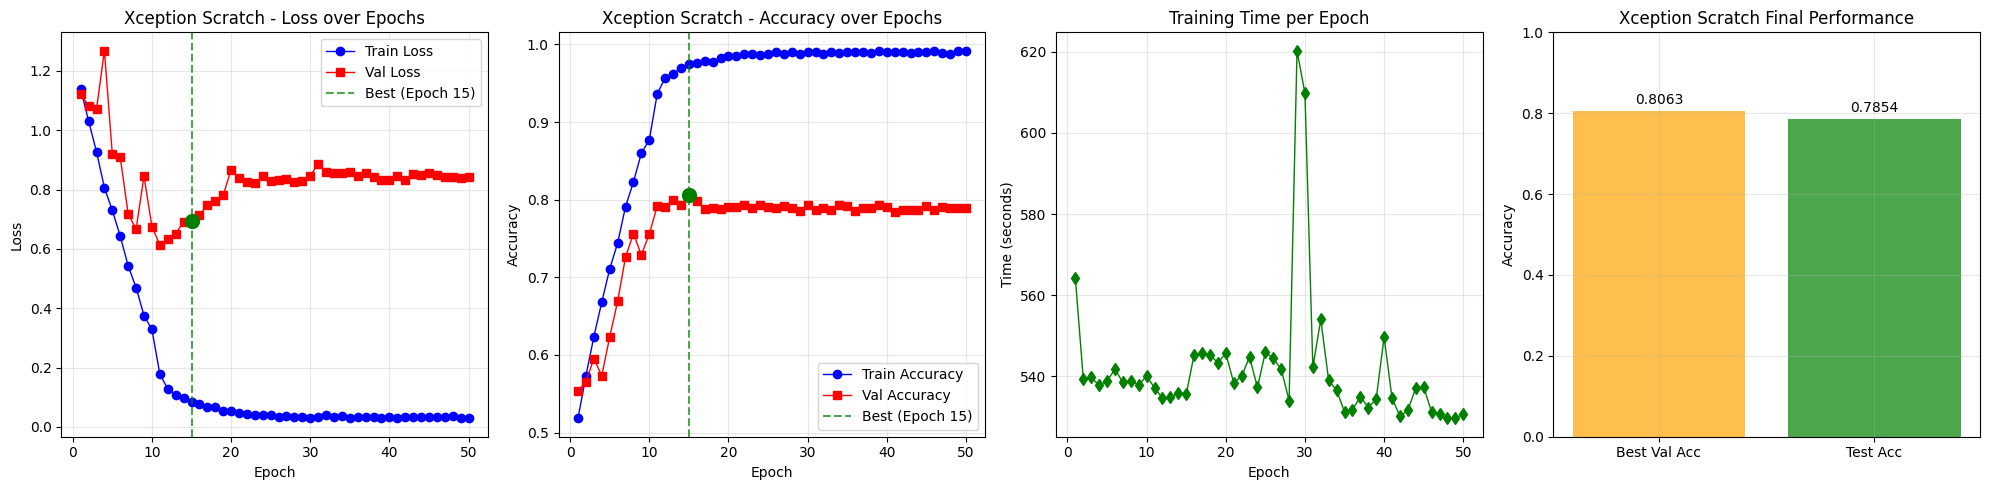


‚è∞ Final Timing Summary:
‚îÇ Total Training: 27082.53s (451.4 min)
‚îÇ Average per Epoch: 541.65s
‚îÇ Testing Time: 73.53s
‚îÇ Total Runtime: 27156.06s

üîÄ Xception Scratch Training - Fixed Version:
‚îÇ ‚úÖ Fixed inplace operations: All ReLU layers use inplace=False
‚îÇ ‚úÖ Custom architecture: Built from ground up
‚îÇ ‚úÖ Depthwise separable convolutions: Core Xception innovation
‚îÇ ‚úÖ No transfer learning: Learns cricket features from scratch
‚îÇ ‚úÖ Data augmentation: Robust training with limited data
‚îÇ ‚úÖ Proper initialization: Xavier/He weight initialization
‚îÇ ‚úÖ Learning rate scheduling: Adaptive learning rate decay
‚îÇ ‚úÖ Clean dataset: 'random_occlusion' folder excluded
‚îÇ ‚úÖ Gradient computation: Fixed backward pass issues


In [8]:

# -----------------------------
# 4. Training Setup for Scratch Training
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Higher LR for scratch training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay

print(f"\nüìã Training Configuration:")
print(f"‚îÇ Model: Xception (from scratch)")
print(f"‚îÇ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"‚îÇ Weight Decay: 1e-4")
print(f"‚îÇ Loss Function: CrossEntropyLoss")
print(f"‚îÇ Batch Size: 16")
print(f"‚îÇ LR Scheduler: StepLR (decay every 10 epochs)")
print(f"‚îÇ Device: {device}")
print(f"‚îÇ Data: Filtered + Augmented")

# -----------------------------
# 5. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50  # More epochs needed for scratch training

# Initialize best model tracking (using val_acc for scratch training)
best_val_acc = 0.0
best_model_state = None
best_epoch = 0
best_val_loss = float('inf')

print(f"\nüöÄ Starting Xception Training from Scratch for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Update learning rate
    scheduler.step()
    
    # Check if this is the best model (using val_acc for scratch training)
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_xception_scratch_filtered.pth')
    print(f"\nüíæ Best model saved as 'best_cricket_xception_scratch_filtered.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times,
    'learning_rate': [scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']] * epochs
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_xception_scratch_filtered_history.csv', index=False)
print("\nüíæ Training history saved to 'cricket_xception_scratch_filtered_history.csv'")

print(f"\nüéâ Xception Scratch Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 6. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Testing completed in {test_time:.2f}s")
print("\nüìã Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\nüìä Cricket Classification Performance (Xception - Scratch Training):")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"‚îÇ Training Type: From scratch (no pretraining)")

print(f"\nüíæ Files saved:")
print(f"‚îÇ best_cricket_xception_scratch_filtered.pth - Best model weights")
print(f"‚îÇ cricket_xception_scratch_filtered_history.csv - Training metrics")

# -----------------------------
# 7. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Xception Scratch (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=1)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=1)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Scratch - Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=1)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=1)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Scratch - Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
plt.plot(range(1, epochs+1), epoch_times, 'g-', marker='d', linewidth=1)
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Xception Scratch Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n‚è∞ Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Training Info
print(f"\nüîÄ Xception Scratch Training - Fixed Version:")
print(f"‚îÇ ‚úÖ Fixed inplace operations: All ReLU layers use inplace=False")
print(f"‚îÇ ‚úÖ Custom architecture: Built from ground up")
print(f"‚îÇ ‚úÖ Depthwise separable convolutions: Core Xception innovation")
print(f"‚îÇ ‚úÖ No transfer learning: Learns cricket features from scratch")
print(f"‚îÇ ‚úÖ Data augmentation: Robust training with limited data")
print(f"‚îÇ ‚úÖ Proper initialization: Xavier/He weight initialization")
print(f"‚îÇ ‚úÖ Learning rate scheduling: Adaptive learning rate decay")
print(f"‚îÇ ‚úÖ Clean dataset: '{ignore_folder}' folder excluded")
print(f"‚îÇ ‚úÖ Gradient computation: Fixed backward pass issues")